In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arch.unitroot import ADF
from statsmodels.tsa.api import VAR
import yfinance as yf
import datetime

In [2]:
end = datetime.datetime.today()
timedelta = datetime.timedelta(days=2 * 365)  # Get 2 years of data
start = end - timedelta
df = yf.download(["BTC-USD", "ETH-USD"], start, end)["Adj Close"]

[*********************100%%**********************]  2 of 2 completed


In [3]:
# Calculate percent changes
df["pct_change_BTC"] = df["BTC-USD"].pct_change()
df["pct_change_ETH"] = df["ETH-USD"].pct_change()
df = df.dropna()
df.head(5)

,BTC-USD,ETH-USD,pct_change_BTC,pct_change_ETH
Date,,,,
2021-12-26,50809.515625,4067.328125,0.007528,-0.006340
2021-12-27,50640.417969,4037.547607,-0.003328,-0.007322
2021-12-28,47588.855469,3800.893066,-0.060259,-0.058613
2021-12-29,46444.710938,3628.531738,-0.024042,-0.045348
2021-12-30,47178.125000,3713.852051,0.015791,0.023514


<Axes: xlabel='Date'>

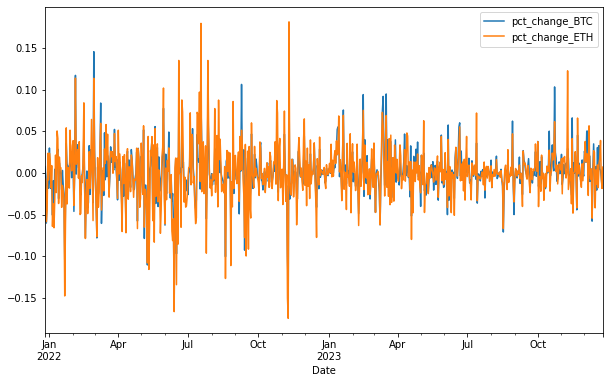

In [4]:
df.loc[:, ["pct_change_BTC", "pct_change_ETH"]].plot(figsize=(10, 6))

In [5]:
# Conduct Augmented Dickey-Fuller tests on pct_change_BTC and pct_change_ETH
ADF_pct_change_BTC = ADF(df["pct_change_BTC"], trend="n", method="bic")
ADF_pct_change_ETH = ADF(df["pct_change_ETH"], trend="n", method="bic")
adf_df = pd.DataFrame({"ADF p-value":[ADF_pct_change_BTC.pvalue, ADF_pct_change_ETH.pvalue]})
adf_df.index = ["pct_change_BTC", "pct_change_ETH"]
adf_df

,ADF p-value
pct_change_BTC,0.0
pct_change_ETH,0.0


As can be seen, because ADF $p$ value is $p < 0.05$, we can decide both percent differences time series are stationary.

In [6]:
pct_data = df.iloc[:, -2:]
pct_data

,pct_change_BTC,pct_change_ETH
Date,,
2021-12-26,0.007528,-0.006340
2021-12-27,-0.003328,-0.007322
2021-12-28,-0.060259,-0.058613
2021-12-29,-0.024042,-0.045348
2021-12-30,0.015791,0.023514
...,...,...
2023-12-21,0.004969,0.017090
2023-12-22,0.002935,0.038839
2023-12-23,-0.005872,-0.007513


In [7]:
# Fit VAR model and select the best lag
model = VAR(pct_data)
model.select_order(maxlags=12, trend="c").summary()  # show the different AIC and BIC values for different lags and we'll pick the minimum.


/home/sscf/.pyenv/versions/3.10.5/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-15.15*,-15.14*,2.621e-07*,-15.15*
1,-15.15,-15.11,2.640e-07,-15.13
2,-15.14,-15.08,2.660e-07,-15.12
3,-15.14,-15.05,2.670e-07,-15.10
4,-15.13,-15.01,2.696e-07,-15.08
5,-15.12,-14.98,2.722e-07,-15.06
6,-15.12,-14.95,2.713e-07,-15.06
7,-15.12,-14.92,2.727e-07,-15.04
8,-15.12,-14.90,2.719e-07,-15.03
9,-15.12,-14.88,2.720e-07,-15.02


According to the order selection, with an optimum lag of 0, a VAR($p$) model does not seem to improve forecasting power and we don't need a VAR(p) fit.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arch.unitroot import ADF
from statsmodels.tsa.api import VAR
import yfinance as yf
import datetime

# Download last 2 years of data for google, microsoft, amazon and nvidia
end = datetime.datetime.today()
timedelta = datetime.timedelta(days=2 * 365)  # Get 2 years of data
start = end - timedelta
df = yf.download(["GOOG", "MSFT", "AMZN", "NVDA"], start, end)["Adj Close"]

[*********************100%%**********************]  4 of 4 completed


In [9]:
df.head()

,AMZN,GOOG,MSFT,NVDA
Date,,,,
2021-12-27,169.669495,148.063995,336.289154,309.023834
2021-12-28,170.660995,146.447998,335.110718,302.802368
2021-12-29,169.201004,146.504501,335.798157,299.596802
2021-12-30,168.644501,146.002502,333.215454,295.452545
2021-12-31,166.716995,144.679504,330.269409,293.704895


<Axes: xlabel='Date'>

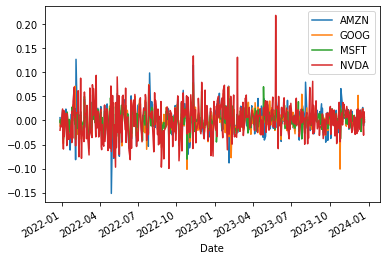

In [10]:
# Create pct_change dataframe
cols = tuple(df.columns)
log_dict = {}
for col in cols:
    log_dict[col] = np.log((df[col] / df[col].shift(1)))
log_df = pd.DataFrame(log_dict, index=df.index).dropna()
log_df.plot()

In [11]:
log_df_VAR = VAR(log_df)
log_df_VAR.select_order(maxlags=12, trend="n").summary()

/home/sscf/.pyenv/versions/3.10.5/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-31.71,-31.57,1.700e-14,-31.65
1,-31.69*,-31.42*,1.720e-14*,-31.59*
2,-31.67,-31.26,1.768e-14,-31.50
3,-31.63,-31.08,1.831e-14,-31.42
4,-31.60,-30.91,1.899e-14,-31.33
5,-31.55,-30.73,1.986e-14,-31.23
6,-31.54,-30.58,2.001e-14,-31.17
7,-31.51,-30.42,2.060e-14,-31.08
8,-31.47,-30.24,2.152e-14,-30.99
9,-31.42,-30.05,2.256e-14,-30.89


Then we select $p=1$ for our VAR($p$) model.

In [12]:
results = VAR(log_df).fit(
    maxlags=None,
    # when maxlags=None criterion to use for VAR order selection is
    # ic{'aic', 'fpe', 'hqic', 'bic', None}
    ic=None,  # ic=None => automatic lag selection
    method="ols",
    trend="n",
    verbose=True,
)
results.summary()

/home/sscf/.pyenv/versions/3.10.5/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 25, Dec, 2023
Time:                     10:10:28
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -31.6208
Nobs:                     500.000    HQIC:                  -31.7028
Log likelihood:           5117.05    FPE:                1.61686e-14
AIC:                     -31.7557    Det(Omega_mle):     1.56614e-14
--------------------------------------------------------------------
Results for equation AMZN
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
L1.AMZN         0.017001         0.067337            0.252           0.801
L1.GOOG        -0.202727         0.086776           -2.336           0.019
L1.MSFT         0.161318         0.105832            1.524           0.127
L1.NVDA   

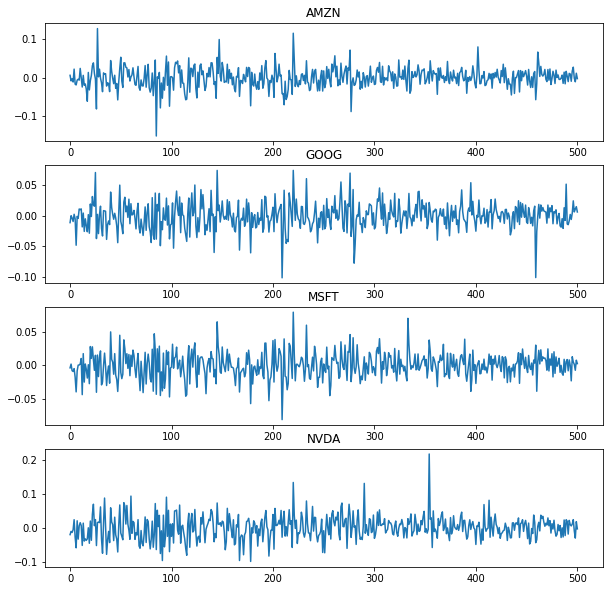

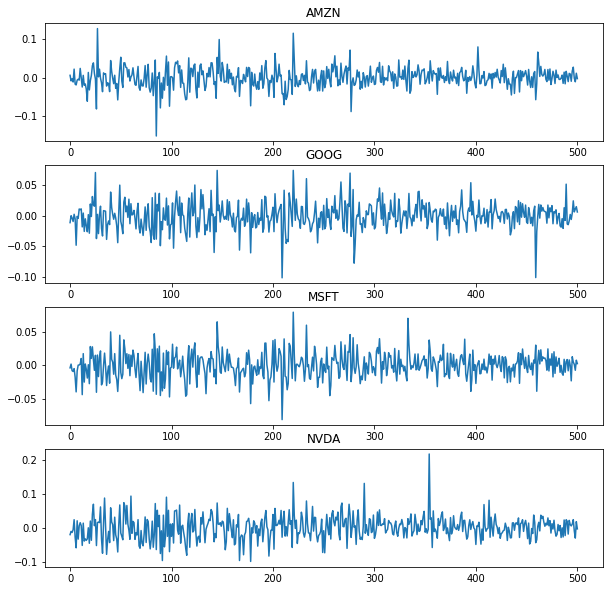

In [13]:
results.plot()

In [14]:
coefs = results.coefs[0]
# const = results.intercept
print(coefs)
# print(const)

[[ 1.70009949e-02 -2.02727323e-01  1.61318352e-01  2.80969149e-03]
 [ 1.82898321e-02 -4.56305451e-02  4.90583399e-02  8.79048615e-05]
 [-7.07469559e-03 -6.75163450e-02  4.18883045e-02  1.01497137e-02]
 [ 1.14434470e-01 -2.64598945e-01  1.54383747e-01  4.97608132e-03]]


In [26]:
# Store coefficients in a dataframe, all lag 1
coef_df_var1 = pd.DataFrame(coefs, columns=["AMZN coef", "GOOG coef", "MSFT coef", "NVDA coef"],
                            index=["AMZN equation", "GOOG equation", "MSFT equation", "NVDA equation"])
coef_df_var1

,AMZN coef,GOOG coef,MSFT coef,NVDA coef
AMZN equation,0.017001,-0.202727,0.161318,0.002810
GOOG equation,0.018290,-0.045631,0.049058,0.000088
MSFT equation,-0.007075,-0.067516,0.041888,0.010150
NVDA equation,0.114434,-0.264599,0.154384,0.004976


Now let's use our VAR(1) model to forecast GOOG percent returns:

/tmp/ipykernel_338/1935076254.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  log_df[f"Cumulative GOOG VAR(1)_{i}"] = log_df[f"GOOG VAR(1)_{i}"].cumsum()
/tmp/ipykernel_338/1935076254.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  log_df[f"GOOG VAR(1)_{i}"] = log_df["AMZN"].shift(1) * coef_df_var1.iloc[1, 0] + log_df["GOOG"].shift(1) * coef_df_var1.iloc[1, 1] + log_df["MSFT"].shift(1) * coef_df_var1.iloc[1, 2] + log_df["NVDA"].shift(1) * coef_df_var1.iloc[1, 3] + np.random.normal(0, log_df.loc[:, ["GOOG"]].std(), len(lo

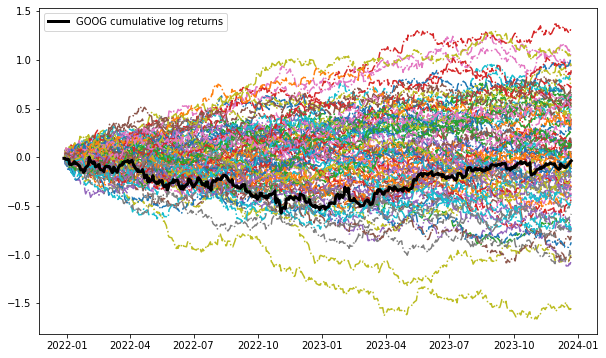

In [57]:

size = 100
for i in range(size):
    log_df[f"GOOG VAR(1)_{i}"] = log_df["AMZN"].shift(1) * coef_df_var1.iloc[1, 0] + log_df["GOOG"].shift(1) * coef_df_var1.iloc[1, 1] + log_df["MSFT"].shift(1) * coef_df_var1.iloc[1, 2] + log_df["NVDA"].shift(1) * coef_df_var1.iloc[1, 3] + np.random.normal(0, log_df.loc[:, ["GOOG"]].std(), len(log_df.loc[:, ["GOOG"]]))
    log_df[f"Cumulative GOOG VAR(1)_{i}"] = log_df[f"GOOG VAR(1)_{i}"].cumsum()
log_df["Cumulative GOOG"] = log_df["GOOG"].cumsum()
# log_df["Cumulative GOOG VAR(1)"] = log_df["GOOG VAR(1)"].cumsum()
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(size):
    ax.plot(log_df.index, log_df[f"Cumulative GOOG VAR(1)_{i}"], linestyle="-.")
ax.plot(log_df.index, log_df["Cumulative GOOG"], linestyle="-", linewidth=3, label="GOOG cumulative log returns", color="black")
ax.legend()


> As we can see, this is a shit fit that has no use whatsoever.

Now, let's use MORE data:

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arch.unitroot import ADF
from statsmodels.tsa.api import VAR
import yfinance as yf
import datetime

# Download last 2 years of data for google, microsoft, amazon and nvidia
end = datetime.datetime.today()
timedelta = datetime.timedelta(days=2 * 365)  # Get 2 years of data
start = end - timedelta
df = yf.download(["GOOG", "MSFT", "AMZN", "NVDA", "AAPL", "META", "TSLA", "HSBC"], start, end)["Adj Close"]

[*********************100%%**********************]  8 of 8 completed


In [60]:
df.head()

,AAPL,AMZN,GOOG,HSBC,META,MSFT,NVDA,TSLA
Date,,,,,,,,
2021-12-27,178.292877,169.669495,148.063995,26.898523,346.179993,336.289124,309.023804,364.646667
2021-12-28,177.264603,170.660995,146.447998,26.970087,346.220001,335.110718,302.802368,362.823334
2021-12-29,177.353622,169.201004,146.504501,27.032701,342.940002,335.798157,299.596802,362.063324
2021-12-30,176.186920,168.644501,146.002502,26.987976,344.359985,333.215454,295.452484,356.779999
2021-12-31,175.564056,166.716995,144.679504,26.970087,336.350006,330.269440,293.704895,352.260010


<Axes: xlabel='Date'>

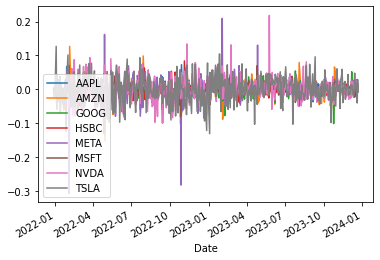

In [61]:
# Create pct_change dataframe
cols = tuple(df.columns)
log_dict = {}
for col in cols:
    log_dict[col] = np.log((df[col] / df[col].shift(1)))
log_df = pd.DataFrame(log_dict, index=df.index).dropna()
log_df.plot()

In [62]:
log_df_VAR = VAR(log_df)
log_df_VAR.select_order(maxlags=12, trend="n").summary()

/home/sscf/.pyenv/versions/3.10.5/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-63.30,-62.76,3.217e-28,-63.09
1,-63.20*,-62.11*,3.558e-28*,-62.77*
2,-63.11,-61.46,3.908e-28,-62.46
3,-63.02,-60.83,4.281e-28,-62.16
4,-62.88,-60.14,4.933e-28,-61.80
5,-62.78,-59.49,5.457e-28,-61.49
6,-62.72,-58.88,5.834e-28,-61.21
7,-62.60,-58.21,6.614e-28,-60.87
8,-62.49,-57.55,7.396e-28,-60.55
9,-62.36,-56.87,8.495e-28,-60.20


Then we proceed with a VAR($1$) model.

In [63]:
results = VAR(log_df).fit(
    maxlags=None,
    # when maxlags=None criterion to use for VAR order selection is
    # ic{'aic', 'fpe', 'hqic', 'bic', None}
    ic=None,  # ic=None => automatic lag selection
    method="ols",
    trend="n",
    verbose=True,
)
results.summary()

/home/sscf/.pyenv/versions/3.10.5/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 25, Dec, 2023
Time:                     11:49:09
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -62.8228
Nobs:                     500.000    HQIC:                  -63.1506
Log likelihood:           10228.8    FPE:                3.03477e-28
AIC:                     -63.3623    Det(Omega_mle):     2.67286e-28
--------------------------------------------------------------------
Results for equation AAPL
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
L1.AAPL        -0.055570         0.076946           -0.722           0.470
L1.AMZN         0.061127         0.047781            1.279           0.201
L1.GOOG        -0.029381         0.063413           -0.463           0.643
L1.HSBC   

Let's forecast AMZN price using 1 lags of AAPL, META, MSFT:

In [66]:
coefs = results.coefs[0]
# const = results.intercept
print(coefs)
# print(const)

[[-0.05556994  0.06112725 -0.0293811   0.00427216 -0.04506396  0.1235874
   0.0234467  -0.04695206]
 [-0.18786008  0.07970563 -0.08528149 -0.00683349 -0.13750294  0.2494571
   0.05801104 -0.04165733]
 [-0.20677331  0.04368743  0.01922448  0.09876697 -0.03596811  0.11495207
   0.03081098 -0.0282158 ]
 [-0.0326854   0.11665522 -0.11543861 -0.03912085  0.00782327 -0.03425271
   0.01751973  0.0051854 ]
 [-0.42072634  0.01920818 -0.10617931  0.03846914 -0.00542012  0.53529016
   0.01850936 -0.04746695]
 [-0.13385666  0.02345849 -0.01243574  0.02980144 -0.04391206  0.09011774
   0.04488144 -0.03832723]
 [-0.06603708  0.1481956  -0.22292137 -0.02355631 -0.04272344  0.18321224
   0.04360213 -0.05201695]
 [ 0.16738557  0.0595592  -0.18840311 -0.01348726 -0.03592715  0.09849378
   0.0509184  -0.08986194]]


In [70]:
coefs_dict = {"AAPL":coefs[1, 0], "META":coefs[1, 4], "MSFT":coefs[1, 5]}
coefs_dict

{'AAPL': -0.187860076287427,
 'META': -0.13750293520384127,
 'MSFT': 0.24945710258295045}

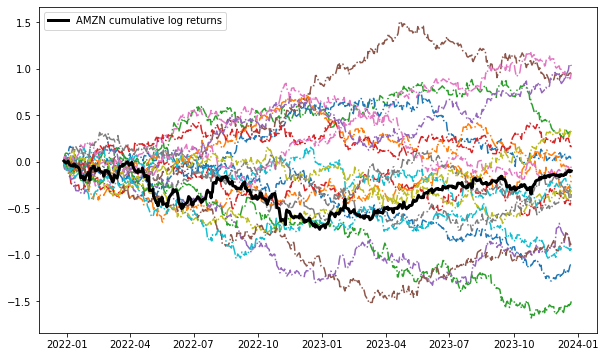

In [96]:
AMZN_var1 = np.sum(np.array([coefs_dict[ticker]*log_df[ticker] for ticker in ["AAPL", "META", "MSFT"]]), axis=0)
log_df["AMZN VAR(1)"] = AMZN_var1
AMZN_resid = log_df["AMZN"] - log_df["AMZN VAR(1)"]
resid_std = AMZN_resid.std()

size = 20
for i in range(size):
    log_df[f"AMZN_VAR_{i}"] = AMZN_var1 + np.random.normal(0, resid_std, len(log_df["AMZN VAR(1)"]))
    log_df[f"Cumulative AMZN_VAR_{i}"] = log_df[f"AMZN_VAR_{i}"].cumsum()
log_df["Cumulative AMZN"] = log_df["AMZN"].cumsum()
    
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(size):
    ax.plot(log_df.index, log_df[f"Cumulative AMZN_VAR_{i}"], linestyle="-.")
ax.plot(log_df.index, log_df["Cumulative AMZN"], linestyle="-", linewidth=3, label="AMZN cumulative log returns", color="black")
ax.legend()